In [1]:

import os 
import getpass
from dotenv import load_dotenv

## retriever
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores.base import VectorStoreRetriever

## tool
from langgraph.prebuilt import ToolExecutor
from langchain.tools.retriever import create_retriever_tool

## agent
import operator
from typing import Annotated, Sequence, TypedDict, Literal

from langchain_core.messages import BaseMessage

## Nodes and Edges
import json
import operator
from typing import Annotated, Sequence, TypedDict, List

from langchain import hub
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain_core.messages import BaseMessage, FunctionMessage, HumanMessage
from langchain_core.documents import Document
from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolInvocation
from langchain_core.output_parsers import StrOutputParser

## web retriever
from langchain_teddynote.tools.tavily import TavilySearch

## Graph
from langgraph.graph import END, StateGraph

## Response
import pprint
from langchain_core.messages import HumanMessage
from langchain.prompts import ChatPromptTemplate
# , MessagesPlaceholder
# from langchain_core.messages import BaseMessage, FunctionMessage, HumanMessage
# from langchain.tools.render import format_tool_to_openai_function
# from langgraph.graph import END, StateGraph

c:\Users\ghckd\anaconda3\envs\voltai\Lib\site-packages\IPython\core\interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


## API Key Setting

In [2]:
def _set_if_undefined(var: str):
    # 주어진 환경 변수가 설정되어 있지 않다면 사용자에게 입력을 요청하여 설정합니다.
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


# OPENAI_API_KEY 환경 변수가 설정되어 있지 않으면 사용자에게 입력을 요청합니다.
_set_if_undefined("OPENAI_API_KEY")
# LANGCHAIN_API_KEY 환경 변수가 설정되어 있지 않으면 사용자에게 입력을 요청합니다.
_set_if_undefined("LANGCHAIN_API_KEY")
# TAVILY_API_KEY 환경 변수가 설정되어 있지 않으면 사용자에게 입력을 요청합니다.
_set_if_undefined("TAVILY_API_KEY")

# LangSmith 추적 기능을 활성화합니다. (선택적)
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

In [3]:
input_data = "../참고논문_1.pdf"

## retriever(검색기) 생성

In [4]:
def embedding_file(file: str) -> VectorStoreRetriever:
    """문서를 청크 단위로 분할하고 임베딩 모델(text-embedding-ada-002)을 통해 임베딩하여 vector store에 저장합니다. 이후 vector store를 기반으로 검색하는 객체를 생성합니다. 

    Args:
        file (str): pdf 문서 경로

    Returns:
        VectorStoreRetriever: 검색기 
    """
    
    ## 긴 텍스트를 작은 청크로 나누는 데 사용되는 클래스
    splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(       
        chunk_size=500,         ## 최대 청크 길이 정의
        chunk_overlap=100,      ## 청크 간 겹침 길이 정의
        separators=["\n\n"]     ## 텍스트를 나눌 때 사용할 구분자를 지정 (문단)
    )
    
    ## PDF 파일 불러오기
    loader = PyPDFLoader(f"{file}")
    docs = loader.load_and_split(text_splitter=splitter)
    
    ## Embedding 생성 및 vector store에 저장
    embeddings = OpenAIEmbeddings()
    vector_store = FAISS.from_documents(
        documents=docs,         ## 벡터 저장소에 추가할 문서 리스트
        embedding=embeddings    ## 사용할 임베딩 함수
    )
    
    ## 검색기로 변환: 현재 벡터 저장소를 기반으로 VectorStoreRetriever 객체를 생성하는 기능을 제공
    retriever = vector_store.as_retriever(
        search_type="similarity"    ## 어떻게 검색할 것인지? default가 유사도
    )

    return retriever

In [5]:
retriever = embedding_file(file=input_data)

## 쿼리 라우팅과 문서 평가
- 쿼리 라우팅: 사용자의 쿼리를 분석하여 적절한 정보 소스로 라우팅한다. 
- 문서 평가: 검색된 문서의 품질과 관련성을 평가하여 최종 결과의 정확성을 높인다. 

In [8]:
# 사용자 쿼리를 가장 관련성 높은 데이터 소스로 라우팅하는 데이터 모델
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    # 데이터 소스 선택을 위한 리터럴 타입 필드
    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

In [9]:
# LLM 초기화 및 함수 호출을 통한 구조화된 출력 생성
llm_roouter = ChatOpenAI(model="gpt-4o", temperature=0)
structured_llm_router = llm_roouter.with_structured_output(RouteQuery)

In [10]:
# 시스템 메시지와 사용자 질문을 포함한 프롬프트 템플릿 생성
system = """You are an expert in extracting key variables and concepts from scientific literature on battery technology.
Your task is to analyze user-provided questions and identify the specific variables, parameters, or concepts related to battery research from the input text.

The input text will consist of technical content, including battery performance metrics, materials, and experimental results."""

# Routing 을 위한 프롬프트 템플릿 생성
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# 프롬프트 템플릿과 구조화된 LLM 라우터를 결합하여 질문 라우터 생성
question_router = route_prompt | structured_llm_router

In [11]:
print(
    question_router.invoke(
        {"question": "소재들은 몇도에서 가공되었어?"}
    )
)

datasource='vectorstore'


## 검색 평가기 (Retrieval Grader)

In [12]:
# 문서 평가를 위한 데이터 모델 정의
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

In [13]:
# LLM 초기화 및 함수 호출을 통한 구조화된 출력 생성
llm_retrieval_grader = ChatOpenAI(model="gpt-4o", temperature=0)
structured_llm_grader = llm_retrieval_grader.with_structured_output(GradeDocuments)

In [14]:
# 시스템 메시지와 사용자 질문을 포함한 프롬프트 템플릿 생성
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# 문서 검색결과 평가기 생성
retrieval_grader = grade_prompt | structured_llm_grader

In [15]:
# 사용자 질문 설정
question = "삼성전자가 만든 생성형 AI 의 이름은?"

# 질문에 대한 관련 문서 검색
docs = retriever.invoke(question)

# 검색된 문서의 내용 가져오기
retrieved_doc = docs[1].page_content

# 평가 결과 출력
print(retrieval_grader.invoke({"question": question, "document": retrieved_doc}))

binary_score='no'


## 답변 생성을 위한 RAG 체인 생성

In [16]:
# prompt 설정
prompt = PromptTemplate(
    template="""
    Based on the following document, please provide an answer to the given question.

    Document:
    {context}

    Question:
    {question}

    Answer:
    """,
    input_variables=["context", "question"],
    )

# LLM 초기화
llm_generator = ChatOpenAI(model_name="gpt-4o", temperature=0)

# 문서 포맷팅 함수
def format_docs(docs):
    return "\n\n".join(
        [
            f'<document><content>{doc.page_content}</content><source>{doc.metadata["source"]}</source><page>{doc.metadata["page"]+1}</page></document>'
            for doc in docs
        ]
    )

# RAG 체인 생성
rag_chain = prompt | llm_generator | StrOutputParser()

## 답변의 할루시네이션 checker 추가

In [17]:
# 할루시네이션 체크를 위한 데이터 모델 정의
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

In [18]:
# 함수 호출을 통한 LLM 초기화
llm_halluci_checker = ChatOpenAI(model="gpt-4o", temperature=0)
structured_llm_halluci_checker = llm_halluci_checker.with_structured_output(GradeHallucinations)

In [19]:
# 프롬프트 설정
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
    Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""

# 프롬프트 템플릿 생성
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

# 환각 평가기 생성
hallucination_grader = hallucination_prompt | structured_llm_halluci_checker

## 답변의 relevant checker 추가

In [20]:
class GradeAnswer(BaseModel):
    """Binary scoring to evaluate the appropriateness of answers to questions"""

    binary_score: str = Field(
        description="Indicate 'yes' or 'no' whether the answer solves the question"
    )

In [21]:
# 함수 호출을 통한 LLM 초기화
llm_grader = ChatOpenAI(model="gpt-4o", temperature=0)
structured_llm_grader = llm_grader.with_structured_output(GradeAnswer)

In [22]:
# 프롬프트 설정
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

# 프롬프트 템플릿과 구조화된 LLM 평가기를 결합하여 답변 평가기 생성
answer_grader = answer_prompt | structured_llm_grader

## 퀴리 재작성 (Query Rewriter)

In [23]:
# LLM 초기화
llm_rewriter = ChatOpenAI(model="gpt-4o", temperature=0)

In [24]:
# Query Rewriter 프롬프트 정의(자유롭게 수정이 가능합니다)
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""

# Query Rewriter 프롬프트 템플릿 생성
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

# Query Rewriter 생성
question_rewriter = re_write_prompt | llm_rewriter | StrOutputParser()

## 웹 검색 도구

In [28]:
# 웹 검색 도구 생성
web_search_tool = TavilySearch(max_results=3)

## GraphState 정의

In [31]:
# 그래프의 상태 정의
class GraphState(TypedDict):
    """
    그래프의 상태를 나타내는 데이터 모델

    Attributes:
        question: 질문
        generation: LLM 생성된 답변
        documents: 도큐먼틑 리스트
    """

    question: Annotated[str, "User question"]
    generation: Annotated[str, "LLM generated answer"]
    documents: Annotated[List[str], "List of documents"]

## Nodes 정의

In [ ]:
# 문서 검색 노드
def retrieve(state):
    print("==== [RETRIEVE] ====")
    question = state["question"]

    # 문서 검색 수행
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


# 답변 생성 노드
def generate(state):
    print("==== [GENERATE] ====")
    # 질문과 문서 검색 결과 가져오기
    question = state["question"]
    documents = state["documents"]

    # RAG 답변 생성
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


# 문서 관련성 평가 노드
def grade_documents(state):
    print("==== [CHECK DOCUMENT RELEVANCE TO QUESTION] ====")
    # 질문과 문서 검색 결과 가져오기
    question = state["question"]
    documents = state["documents"]

    # 각 문서에 대한 관련성 점수 계산
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            # 관련성이 있는 문서 추가
            filtered_docs.append(d)
        else:
            # 관련성이 없는 문서는 건너뛰기
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


# 질문 재작성 노드
def transform_query(state):
    print("==== [TRANSFORM QUERY] ====")
    # 질문과 문서 검색 결과 가져오기
    question = state["question"]
    documents = state["documents"]

    # 질문 재작성
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


# 웹 검색 노드
def web_search(state):
    print("==== [WEB SEARCH] ====")
    # 질문과 문서 검색 결과 가져오기
    question = state["question"]

    # 웹 검색 수행
    web_results = web_search_tool.invoke({"query": question})
    web_results_docs = [
        Document(
            page_content=web_result["content"],
            metadata={"source": web_result["url"]},
        )
        for web_result in web_results
    ]

    return {"documents": web_results_docs, "question": question}


In [ ]:
# 질문 라우팅 노드
def route_question(state):
    print("==== [ROUTE QUESTION] ====")
    # 질문 가져오기
    question = state["question"]
    # 질문 라우팅
    source = question_router.invoke({"question": question})
    # 질문 라우팅 결과에 따른 노드 라우팅
    if source.datasource == "web_search":
        print("==== [ROUTE QUESTION TO WEB SEARCH] ====")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("==== [ROUTE QUESTION TO VECTORSTORE] ====")
        return "vectorstore"


# 문서 관련성 평가 노드
def decide_to_generate(state):
    print("==== [DECISION TO GENERATE] ====")
    # 질문과 문서 검색 결과 가져오기
    question = state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # 모든 문서가 관련성 없는 경우 질문 재작성
        print(
            "==== [DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY] ===="
        )
        return "transform_query"
    else:
        # 관련성 있는 문서가 있는 경우 답변 생성
        print("==== [DECISION: GENERATE] ====")
        return "generate"


def hallucination_check(state):
    print("==== [CHECK HALLUCINATIONS] ====")
    # 질문과 문서 검색 결과 가져오기
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    # 환각 평가
    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Hallucination 여부 확인
    if grade == "yes":
        print("==== [DECISION: GENERATION IS GROUNDED IN DOCUMENTS] ====")

        # 답변의 관련성(Relevance) 평가
        print("==== [GRADE GENERATED ANSWER vs QUESTION] ====")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score

        # 관련성 평가 결과에 따른 처리
        if grade == "yes":
            print("==== [DECISION: GENERATED ANSWER ADDRESSES QUESTION] ====")
            return "relevant"
        else:
            print("==== [DECISION: GENERATED ANSWER DOES NOT ADDRESS QUESTION] ====")
            return "not relevant"
    else:
        print("==== [DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY] ====")
        return "hallucination"


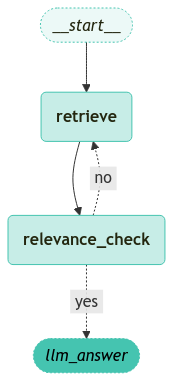

In [9]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)


In [13]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, random_uuid, invoke_graph

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="""Below are instructions for filling out 23 items by referring to the examples. The values shown to the right of the colon (“:”) are examples; please delete them after reviewing and rewrite them with the values found in the PDF. If any item is not mentioned in the PDF, do not remove it—write “None.”
1. Electrode (only coin cell)
1.1 Cathode active material: NCM-622
1.2 Lithium source: LiOH
1.3 Nickel supplied during the co-precipitation process of the precursor: NiSO4·6H2O
1.4 Cobalt supplied during the co-precipitation process of the precursor: CoSO4·7H2O
1.5 Manganese supplied during the co-precipitation process of the precursor: MnSO4·H2O
1.6 Co-precipitation solution: NaOH, 4M
1.7 Crystallization method (Hydrothermal or Sintering): Hydrothermal
1.8 Crystallization temperature: 100°C
1.9 Crystallization time: 12 hr
1.10 Active material : Conductive additive : Binder ratio: 90 : 5 : 5
1.11 Electrolyte: LiPF6 (EC, EMC, DEC mixture in a 1:1:1 volume ratio)
1.12 Doping: Zr4+ doping
1.13 Coating: ZrO2 coating
1.14 Additive: FEC 10% addition
1.15 Electrode thickness: 100 µm
1.16 only Cathode Electrode diameter: 14π
1.17 Loading density: 0.005 g/cm^2
1.18 Commercial NCM (check if specified in the paper): No
2. Cathode Performance
2.1 Capacity at all C-rate, mAh/g (with electrode state; e.g., coated or uncoated) : 214.5 mAh/g
2.2 Voltage range: 2.8–4.3 V
2.3 Temperature: Room temperature and 55°C
3. Cathode Equipment
3.1 Explanation of SEM results (indicate figure numbers as well):
ex) Fig. 2a, b;the NCM-622 seems to have more or less a spherical morphology with a diameter of 3–5 µm, composed of densely packed primary parti-cles
3.2 Explanation of TEM results: None""")

In [14]:
# 그래프 실행
stream_graph(
    graph=app, 
    inputs=inputs, 
    config=config, 
    node_names=["relevance_check", "llm_answer"]
)
outputs = app.get_state(config).values


🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [RELEVANCE CHECK] ====
yes

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
1. Electrode (only coin cell)
1.1 Cathode active material: NCM622
1.2 Lithium source: Li2CO3
1.3 Nickel supplied during the co-precipitation process of the precursor: NiC4H6O4·4H2O
1.4 Cobalt supplied during the co-precipitation process of the precursor: Co(NO3)2·6H2O
1.5 Manganese supplied during the co-precipitation process of the precursor: MnC4H6O4·4H2O
1.6 Co-precipitation solution: None
1.7 Crystallization method (Hydrothermal or Sintering): Sintering
1.8 Crystallization temperature: 600°C, 700°C, 800°C
1.9 Crystallization time: 12 hr
1.10 Active material : Conductive additive : Binder ratio: None
1.11 Electrolyte: 1.2 M LiPF6 in EC-EMC (3:7 volume ratio) with 2 wt% VC
1.12 Doping: None
1.13 Coating: None
1.14 Additive: None
1.15 Electrode thickness: None
1.16 only Cathode Electrode diameter: None
1.